# Bee vs Wasp Classifier

This network takes in a dataset of bee, wasp, and other animal images specified here: https://www.kaggle.com/jerzydziewierz/bee-vs-wasp

The network outputs a probability vector of what it thinks the image is of, choosing between bee, wasp, and other for its guesses


In [2]:
import cv2
import keras
import os
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.metrics import accuracy
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tqdm import tqdm

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

### Preprocessing

Here I use pandas to format the data into an appropriate form that a network will understand.

I also display some of the intermediate steps to show off what some of the data looks like under the hood.

In [3]:
partition = {}
partition['train'] = 0
partition['test'] = 0

In [4]:
images_root = './kaggle_bee_vs_wasp'
csv_filename = 'labels.csv'
csv_path = os.path.join(images_root, csv_filename)

# get metadata, only using files where photo quality is acceptable (has photo_quality = 1)
md = pd.read_csv(csv_path)
md = md[md.photo_quality==1]
md.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [5]:
# replace '\' with '/'
for idx in tqdm(md.index):
    md.loc[idx, 'path'] = md.loc[idx, 'path'].replace('\\', '/')
    
md.head()

100%|██████████| 7035/7035 [00:01<00:00, 3791.77it/s]


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


### Show that there are about equal amounts of bee, wasp, and other data

Text(0.5, 1.0, 'Unique values of dataset')

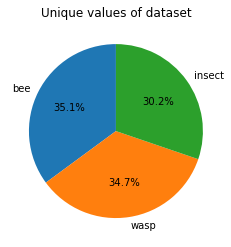

In [6]:
labels = list(md['label'].unique())
y = list(md['label'].value_counts())
plt.pie(y, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Unique values of dataset")

In [7]:
# count images in each section
md = md.query('photo_quality == 1')
md['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [8]:
train_md = md.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_md = md.query('is_validation == 1').reset_index(drop=True)
test_md = md.query('is_final_validation == 1').reset_index(drop=True)

In [9]:
train_md.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee
2,6,bee1/10130729734_f68738333e_w.jpg,1,0,0,0,1,0,0,bee
3,7,bee1/10166485783_9cd6706c72_n.jpg,1,0,0,0,1,0,0,bee
4,8,bee1/10179824_84803290ac_m.jpg,1,0,0,0,1,0,0,bee


In [10]:
val_md.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
1,11,bee1/10290912366_20f0dbdb0e_m.jpg,1,0,0,0,1,1,0,bee
2,15,bee1/10330536605_77cd1d5e37_n.jpg,1,0,0,0,1,1,0,bee
3,24,bee1/10457143913_149e654aaa_n.jpg,1,0,0,0,1,1,0,bee
4,31,bee1/10823834_7f6ddb5bce_n.jpg,1,0,0,0,1,1,0,bee


In [11]:
test_md.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
1,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
2,23,bee1/1044467943_594f56bd36_n.jpg,1,0,0,0,1,0,1,bee
3,37,bee1/1154438668_037d503906_m.jpg,1,0,0,0,1,0,1,bee
4,40,bee1/11609248916_80ea630895_n.jpg,1,0,0,0,1,0,1,bee


In [12]:
# Got dataset formatting function from: https://www.kaggle.com/koshirosato/bee-or-wasp-base-line-using-resnet50
IMG_SIZE = 256

#Creating Datasets
def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(os.path.join(images_root, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_md = create_datasets(train_md, IMG_SIZE)
val_imgs, val_md = create_datasets(val_md, IMG_SIZE)
test_imgs, test_md = create_datasets(test_md, IMG_SIZE)

100%|██████████| 1084/1084 [00:04<00:00, 231.95it/s]


In [13]:
print(train_md.iloc[0])

bee       1
insect    0
wasp      0
Name: 0, dtype: uint8


### Defining the model

I create a neural network using convolutional layers interspersed with ReLU, BatchNormalization, and Dropout layers, which then connects into 2 fully connected layers at the end

In [14]:
def down_conv(module, out_filters=8):
    module.add(Conv2D(out_filters, kernel_size=3, strides=2, padding="same",
                      kernel_regularizer=keras.regularizers.l2(0.001), input_shape=train_imgs.shape[1:])) 
    module.add(Activation('relu'))
    module.add(BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)))
    module.add(Dropout(0.3))

    return module

In [15]:
model = Sequential()

# 3x256x256 --> 4x128x128
model = down_conv(model, out_filters=64)

# 4x128x128 --> 8x64x64
model = down_conv(model, out_filters=64)

# 8x64x64 --> 16x32x32
model = down_conv(model, out_filters=128)

# 16x32x32 --> 32x16x16
model = down_conv(model, out_filters=128)

# 32x16x16 --> 64x8x8
model = down_conv(model, out_filters=256)

# 64x8x8 --> 128x4x4
model = down_conv(model, out_filters=512)

# 128x4x4 --> 128x1x1
model.add(GlobalAveragePooling2D())

model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# 10 -- 3
model.add(Dense(3))
model.add(Activation('softmax'))

In [34]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

### Verify that this model will execute on the GPU:

In [36]:
print("GPU status: ", tf.config.experimental.list_physical_devices('GPU'))
print("Num GPU's: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU status:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPU's:  1


In [37]:
# Learned how to use callbacks to save best epoch here: https://stackoverflow.com/questions/48285129/saving-best-model-in-keras

earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')


history = model.fit(train_imgs, train_md, batch_size=16, epochs=150,
                    validation_data=(test_imgs, test_md), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/150
307/307 [==============================] - 8s 26ms/step - loss: 0.8582 - accuracy: 0.8360 - val_loss: 1.3527 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 2/150
307/307 [==============================] - 7s 22ms/step - loss: 0.9291 - accuracy: 0.8435 - val_loss: 1.3490 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 3/150
307/307 [==============================] - 7s 22ms/step - loss: 1.0032 - accuracy: 0.8305 - val_loss: 1.4246 - val_accuracy: 0.6946 - lr: 0.0010
Epoch 4/150
307/307 [==============================] - 8s 25ms/step - loss: 1.0146 - accuracy: 0.8309 - val_loss: 1.3366 - val_accuracy: 0.7334 - lr: 0.0010
Epoch 5/150
307/307 [==============================] - 7s 22ms/step - loss: 1.0134 - accuracy: 0.8399 - val_loss: 1.3574 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 6/150
307/307 [==============================] - 7s 22ms/step - loss: 1.0544 - accuracy: 0.8260 - val_loss: 1.2499 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 7/150
307/307 [==============================] - 7s 

### Viewing the Results:

The first graph shows loss over time, while the second shows accuracy over time

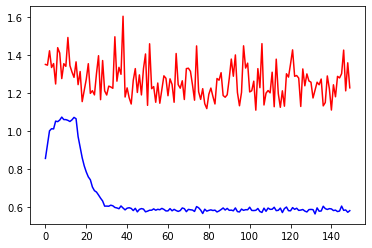

In [38]:
# history keys: loss, accuracy, val_loss, val_accuracy
plt.figure()
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')

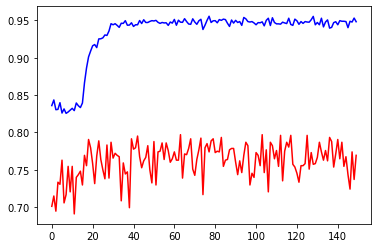

In [39]:
plt.figure()
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')

### Saving the model

In [40]:
model.save("saved_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/assets


### Results:
This model's best epoch was 141 with the minimum validation loss of 1.1128 and a validation accuracy of 79.06%